In [ ]:
#@markdown Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15109 MiB, 15109 MiB


https://github.com/ShivamShrirao/diffusers/tree/main/examples/dreambooth

## Install Requirements

In [ ]:
!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers
%pip install -q -U --pre triton
%pip install -q accelerate transformers ftfy bitsandbytes gradio

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163 kB 28.3 MB/s 
     |████████████████████████████████| 18.7 MB 1.2 MB/s 
     |████████████████████████████████| 143 kB 35.2 MB/s 
     |████████████████████████████████| 4.9 MB 53.8 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 55.9 MB 1.2 MB/s 
     |████████████████████████████████| 5.3 MB 52.9 MB/s 
     |████████████████████████████████| 6.6 MB 55.4 MB/s 
     |████████████████████████████████| 212 kB 65.2 MB/s 
     |████████████████████████████████| 54 kB 1.5 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 2.3 MB 59.6 MB/s 
     |████████████████████████████████| 57 kB 5.8 MB/s 
     |████████████████████████████████| 112 kB 60.4 MB/s 
     |████████

In [ ]:
#@title Login to HuggingFace 🤗

#@markdown You need to accept the model license before downloading or using the Stable Diffusion weights. Please, visit the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4), read the license and tick the checkbox if you agree. You have to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work.
from huggingface_hub import notebook_login
!git config --global credential.helper store
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


### Install xformers from precompiled wheel.

In [ ]:
%pip install -q https://github.com/metrolobo/xformers_wheels/releases/download/1d31a3ac_various_6/xformers-0.0.14.dev0-cp37-cp37m-linux_x86_64.whl
# These were compiled on Tesla T4, should also work on P100, thanks to https://github.com/metrolobo

# If precompiled wheels don't work, install it with the following command. It will take around 40 minutes to compile.
# %pip install git+https://github.com/facebookresearch/xformers@1d31a3a#egg=xformers

     |████████████████████████████████| 102.9 MB 88 kB/s 


## Settings and run

In [ ]:
#@markdown Name/Path of the initial model.
MODEL_NAME = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

#@markdown Path for images of the concept for training.
INSTANCE_DIR = "/content/data/fAIrytale" #@param {type:"string"}
!mkdir -p $INSTANCE_DIR

#@markdown A general name for class like dog for dog images.
CLASS_NAME = "illustration" #@param {type:"string"}
CLASS_DIR = f"/content/data/{CLASS_NAME}"

#@markdown If model weights should be saved directly in google drive (takes around 4-5 GB).
save_to_gdrive = True #@param {type:"boolean"}
if save_to_gdrive:
    from google.colab import drive
    drive.mount('/content/drive')

#@markdown Enter the directory name to save model at.

OUTPUT_DIR = "stable_diffusion_weights/fAIrytale" #@param {type:"string"}
if save_to_gdrive:
    OUTPUT_DIR = "/content/drive/MyDrive/" + OUTPUT_DIR
else:
    OUTPUT_DIR = "/content/" + OUTPUT_DIR

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

!mkdir -p $OUTPUT_DIR

#@markdown sks is a rare identifier, feel free to replace it.

Mounted at /content/drive
[*] Weights will be saved at /content/drive/MyDrive/stable_diffusion_weights/fAIrytale


--2022-10-04 21:08:45--  https://raw.githubusercontent.com/GerardCB/TAED2-fAIrytale/main/data/ytrain.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71881 (70K) [text/plain]
Saving to: ‘ytrain.json’

ytrain.json         100%[===================>]  70.20K  --.-KB/s    in 0.001s  

2022-10-04 21:08:45 (100 MB/s) - ‘ytrain.json’ saved [71881/71881]



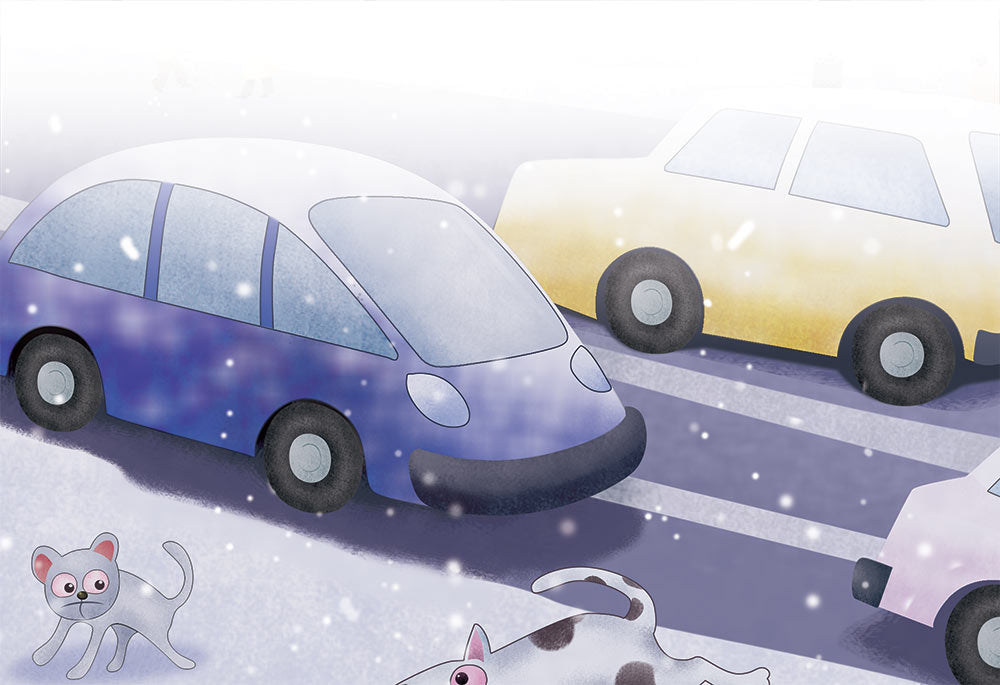

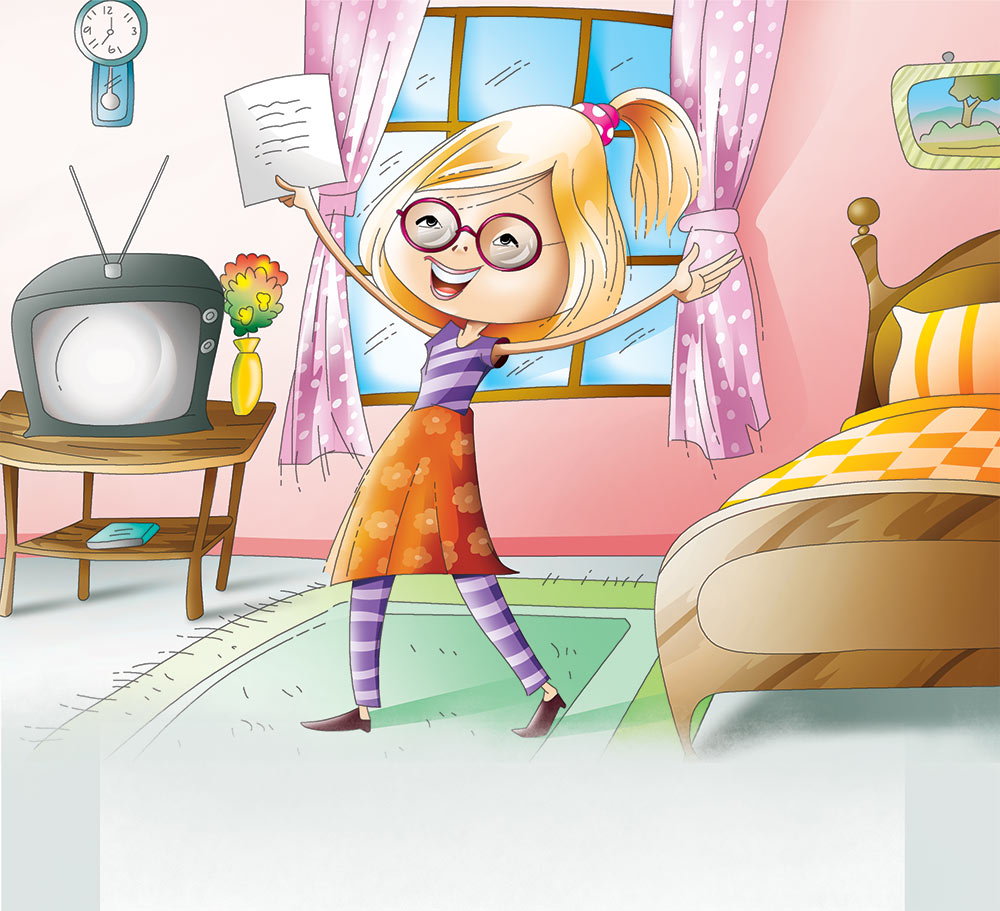

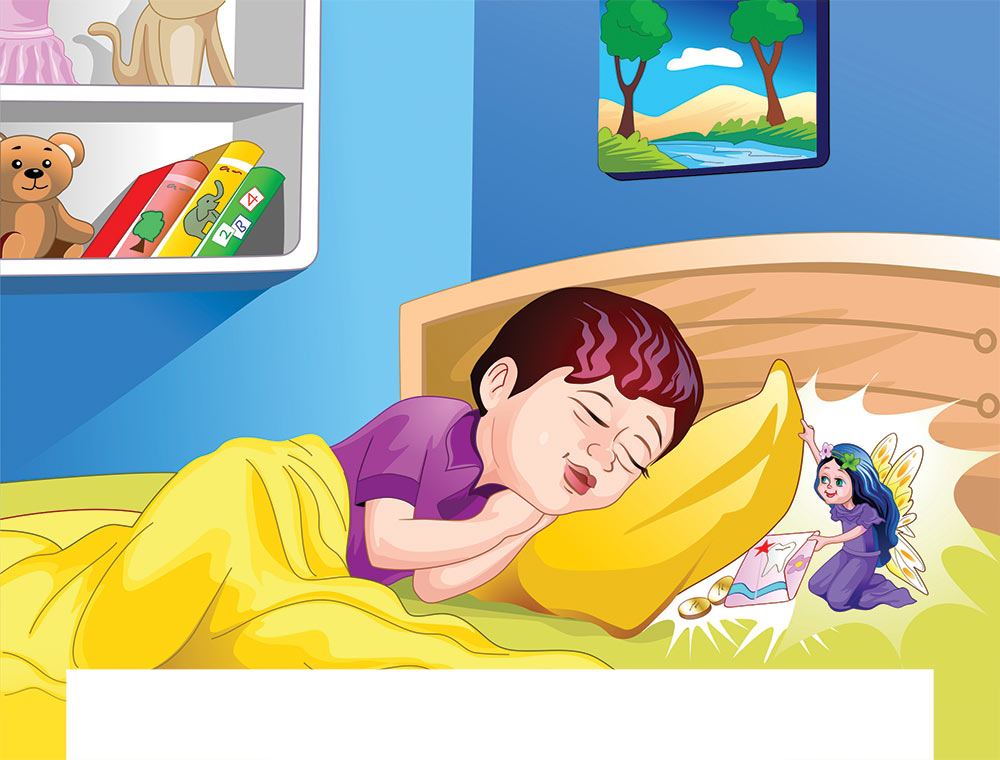

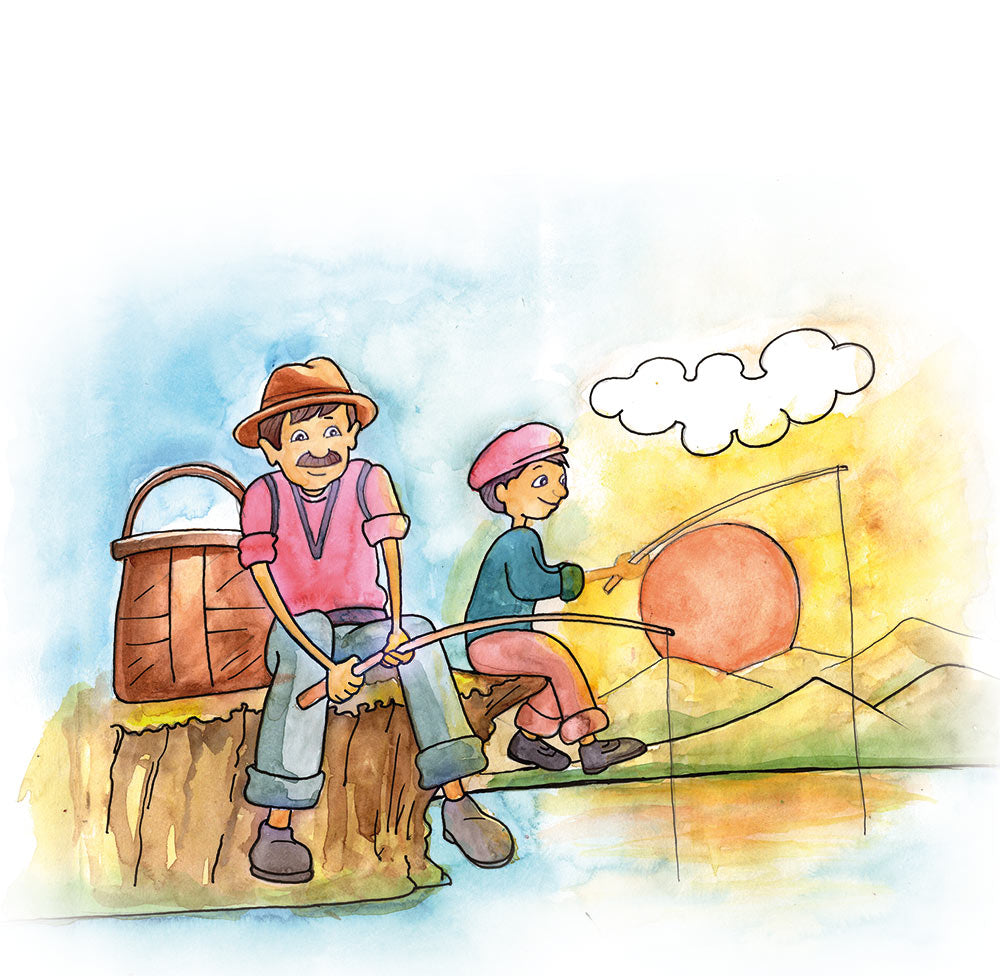

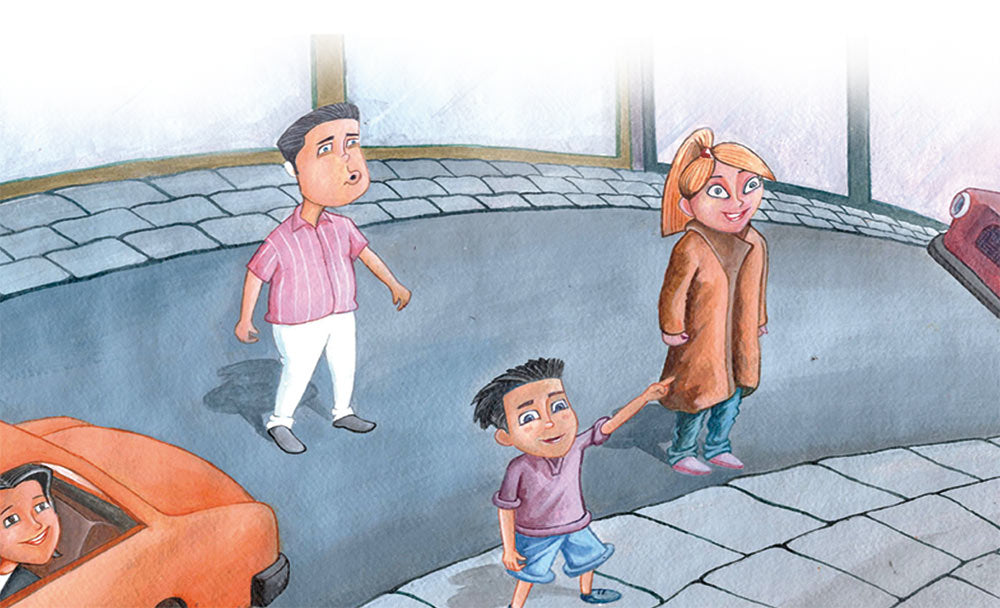

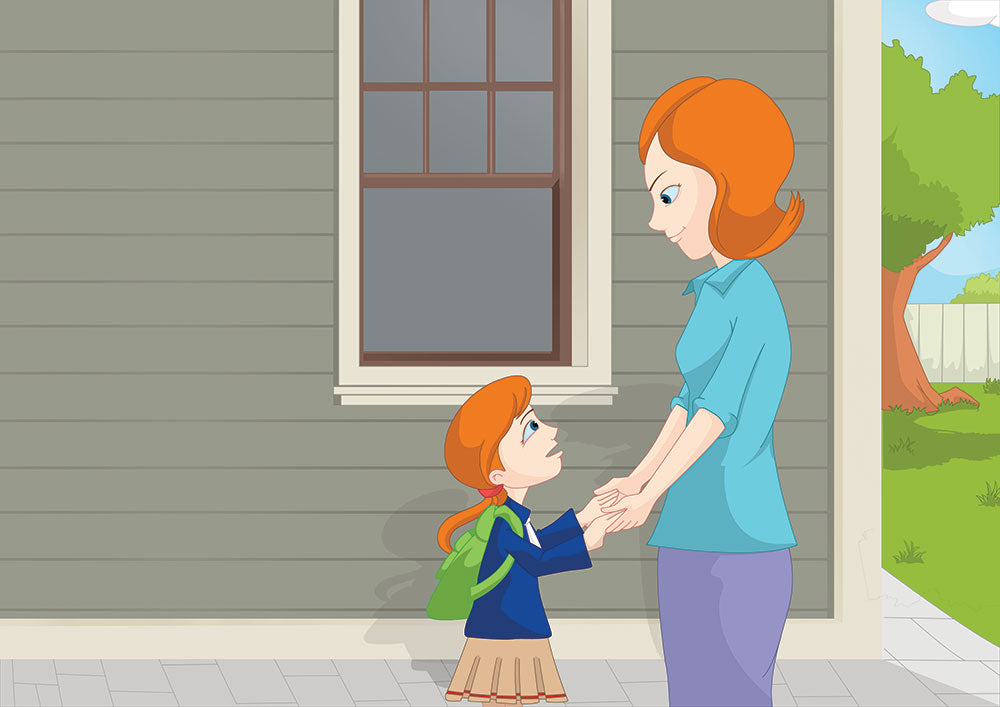

In [ ]:
#@markdown Upload some training images from the fAIrytale training dataset.

import random
import urllib.request
from PIL import Image
import json
import os

num_images = 6 #@param {type:"integer"}

# Download 'ytrain.json' dataset
!wget https://raw.githubusercontent.com/GerardCB/TAED2-fAIrytale/main/data/ytrain.json
with open('/content/ytrain.json', 'r') as f:
    train_books = json.load(f)

# Download images
book_idxs = random.choices(list(train_books.keys()), k=num_images)
for i, idx in enumerate(book_idxs):
    book = train_books[idx]
    image_idx = random.randint(0, len(book)-1)
    image_url = book[image_idx]

    urllib.request.urlretrieve(image_url, os.path.join(INSTANCE_DIR, f"{i}.png"))
    Img = Image.open(os.path.join(INSTANCE_DIR, f"{i}.png"))
    display(Img)


# Start Training

Use the table below to choose the best flags based on your memory and speed requirements. Tested on Tesla T4 GPU.


| `fp16` | `train_batch_size` | `gradient_accumulation_steps` | `gradient_checkpointing` | `use_8bit_adam` | GB VRAM usage | Speed (it/s) |
| ---- | ------------------ | ----------------------------- | ----------------------- | --------------- | ---------- | ------------ |
| fp16 | 1                  | 1                             | TRUE                    | TRUE            | 9.92       | 0.93         |
| no   | 1                  | 1                             | TRUE                    | TRUE            | 10.08      | 0.42         |
| fp16 | 2                  | 1                             | TRUE                    | TRUE            | 10.4       | 0.66         |
| fp16 | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 1.14         |
| no   | 1                  | 1                             | FALSE                   | TRUE            | 11.17      | 0.49         |
| fp16 | 1                  | 2                             | TRUE                    | TRUE            | 11.56      | 1            |
| fp16 | 2                  | 1                             | FALSE                   | TRUE            | 13.67      | 0.82         |
| fp16 | 1                  | 2                             | FALSE                   | TRUE            | 13.7       | 0.83          |
| fp16 | 1                  | 1                             | TRUE                    | FALSE           | 15.79      | 0.77         |


Add `--gradient_checkpointing` flag for around 9.92 GB VRAM usage.

remove `--use_8bit_adam` flag for full precision. Requires 15.79 GB with `--gradient_checkpointing` else 17.8 GB.

### Weights & Biases

Used to track the experiments and perform sweeps.

In [ ]:
!pip install wandb -qqq

import wandb
wandb.login(key="618d82eba5a8f8e0789953a2bcfb6dd1783ec97e")

     |████████████████████████████████| 1.8 MB 32.1 MB/s 
     |████████████████████████████████| 162 kB 68.9 MB/s 
     |████████████████████████████████| 181 kB 59.2 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 162 kB 68.5 MB/s 
     |████████████████████████████████| 158 kB 74.8 MB/s 
     |████████████████████████████████| 157 kB 79.0 MB/s 
     |████████████████████████████████| 157 kB 76.3 MB/s 
     |████████████████████████████████| 157 kB 76.3 MB/s 
     |████████████████████████████████| 157 kB 77.9 MB/s 
     |████████████████████████████████| 157 kB 74.7 MB/s 
     |████████████████████████████████| 157 kB 77.6 MB/s 
     |████████████████████████████████| 157 kB 77.5 MB/s 
     |████████████████████████████████| 156 kB 101.6 MB/s 


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
prior_loss_weight = 1.0
instance_prompt = "a painting in the style of a fAIrytale {CLASS_NAME}"
class_prompt = "a painting in the style of {CLASS_NAME}"
seed = 1337
resolution = 512
train_batch_size = 1
mixed_precision = "fp16"
gradient_accumulation_steps = 1
learning_rate = 5e-6
lr_scheduler = "constant"
lr_warmup_steps = 0
num_class_images = 20
sample_batch_size = 4
max_train_steps = 1000
log_interval = 10

hyperparameter_dict = dict(
    prior_loss_weight = prior_loss_weight,
    instance_prompt = instance_prompt,
    class_prompt = class_prompt,
    seed = seed,
    resolution = resolution,
    train_batch_size = train_batch_size,
    mixed_precision = mixed_precision,
    gradient_accumulation_steps = gradient_accumulation_steps,
    learning_rate = learning_rate,
    lr_scheduler = lr_scheduler,
    lr_warmup_steps = lr_warmup_steps,
    num_class_images = num_class_images,
    sample_batch_size = sample_batch_size,
    max_train_steps = max_train_steps
    log_interval = log_interval
)

config_dictionary = dict(
    params = hyperparameter_dict,
)

run_id = wandb.util.generate_id()
run = wandb.init(
    project="fAIrytale",
    config=config_dictionary,
    settings=wandb.Settings(start_method="thread"),
    id=run_id,
    resume="allow"
)

In [ ]:
artifact = wandb.Artifact('training_images', type='dataset')
artifact.add_dir(INSTANCE_DIR)
run.log_artifact(artifact)

wandb: Adding directory to artifact (/content/data/fAIrytale)... Done. 0.1s


In [ ]:
run_id

'2jgj50yz'

In [ ]:
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME --use_auth_token \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=$prior_loss_weight \
  --instance_prompt="a painting in the style of a fAIrytale {CLASS_NAME}" \
  --class_prompt="a painting in the style of {CLASS_NAME}" \
  --seed=$seed \
  --resolution=$resolution \
  --center_crop \
  --train_batch_size=$train_batch_size \
  --mixed_precision=$mixed_precision \
  --use_8bit_adam \
  --gradient_accumulation_steps=$gradient_accumulation_steps \
  --learning_rate=$learning_rate \
  --lr_scheduler=$lr_scheduler \
  --lr_warmup_steps=$lr_warmup_steps \
  --num_class_images=$num_class_images \
  --sample_batch_size=$sample_batch_size \
  --max_train_steps=$max_train_steps \
  --log_interval=$log_interval \
  --wandb_run_id=$run_id


The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--num_cpu_threads_per_process` was set to `1` to improve out-of-box performance
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
wandb: Currently logged in as: gerardcb_upc. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.13.3
wandb: Run data is saved locally in /content/wandb/run-20221004_213705-2jgj50yz
wandb: Run `wandb offline` to turn off syncing.
wandb: Resuming run driven-wood-12
wandb: ⭐️ View project at https://wandb.ai/gerardcb_upc/fAIrytale
wandb: 🚀 View run at https://wandb.ai/gerardcb_upc/fAIrytale/runs/2jgj50yz

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your e

## Convert weights to ckpt to use in web UIs like AUTOMATIC1111.

In [ ]:
#@markdown Download script
!wget -q https://gist.github.com/jachiam/8a5c0b607e38fcc585168b90c686eb05/raw/2af0a9c0237ed98b863a75e1db21d7ed5541094f/convert_diffusers_to_sd.py

In [ ]:
#@markdown Run conversion.
ckpt_path = OUTPUT_DIR + "/model.ckpt"

half_arg = ""
#@markdown  Whether to convert to fp16, takes half the space (2GB), might loose some quality.
fp16 = False #@param {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_sd.py --model_path $OUTPUT_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

Reshaping encoder.mid.attn_1.q.weight for SD format
Reshaping encoder.mid.attn_1.k.weight for SD format
Reshaping encoder.mid.attn_1.v.weight for SD format
Reshaping encoder.mid.attn_1.proj_out.weight for SD format
Reshaping decoder.mid.attn_1.q.weight for SD format
Reshaping decoder.mid.attn_1.k.weight for SD format
Reshaping decoder.mid.attn_1.v.weight for SD format
Reshaping decoder.mid.attn_1.proj_out.weight for SD format
[*] Converted ckpt saved at /content/drive/MyDrive/stable_diffusion_weights/fAIrytale/model.ckpt


In [ ]:
#@markdown Save model .ckpt to wandb.
artifact = wandb.Artifact('model', type='model')
artifact.add_dir(OUTPUT_DIR)
run.log_artifact(artifact)

wandb: Adding directory to artifact (/content/drive/MyDrive/stable_diffusion_weights/fAIrytale)... Done. 80.2s


In [ ]:
#@markdown End wandb run.
wandb.finish()

## Inference

In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
from IPython.display import display

model_path = OUTPUT_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16).to("cuda")
g_cuda = None

In [ ]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 52362 #@param {type:"number"}
g_cuda.manual_seed(seed)

  0%|          | 0/51 [00:00<?, ?it/s]

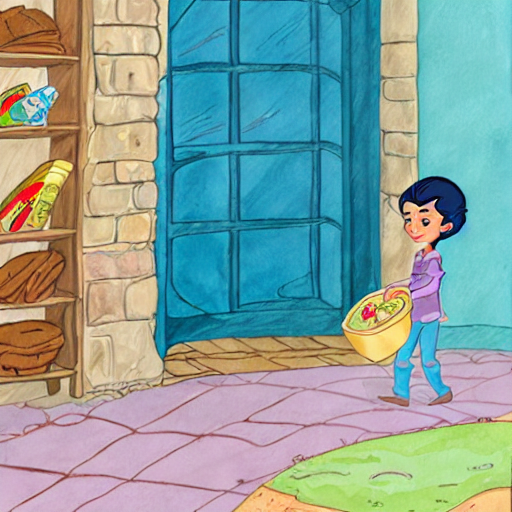

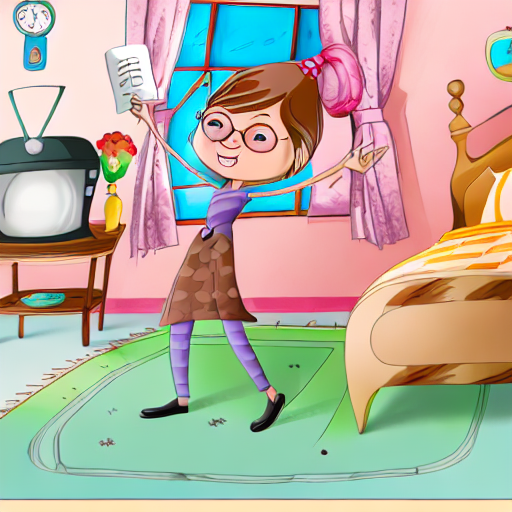

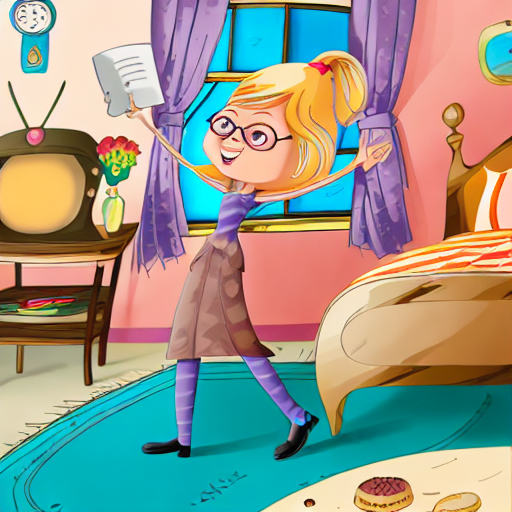

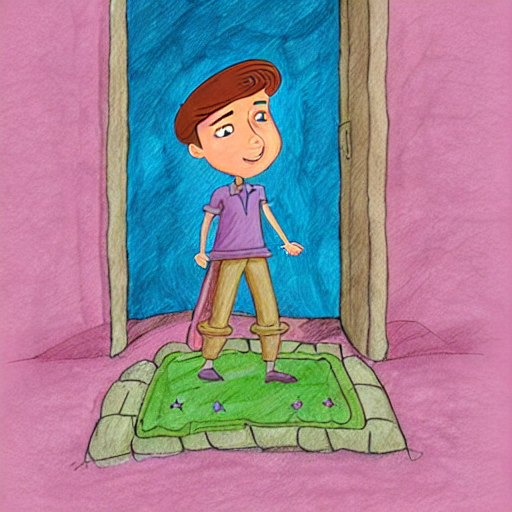

In [ ]:
#@title Run for generating images.

prompt = "a prince in a castle made fom cookies, in the style of a fAIrytale illustration" #@param {type:"string"}
num_samples = 4 #@param {type:"number"}
guidance_scale = 7.5 #@param {type:"number"}
num_inference_steps = 50 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}

with autocast("cuda"), torch.inference_mode():
    images = pipe([prompt] * num_samples, height=height, width=width, num_inference_steps=num_inference_steps, guidance_scale=guidance_scale, generator=g_cuda).images

for img in images:
    display(img)

In [ ]:
#@markdown Run Gradio UI for generating images.
import gradio as gr

def inference(prompt, num_samples, height=512, width=512, num_inference_steps=50, guidance_scale=7.5):
    with torch.autocast("cuda"), torch.inference_mode():
        return pipe(
            [prompt]*int(num_samples), height=int(height), width=int(width),
            num_inference_steps=int(num_inference_steps), guidance_scale=guidance_scale,
            generator=g_cuda
            ).images

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            prompt = gr.Textbox(label="Prompt", value="photo of sks guy, digital painting")
            run = gr.Button(value="Generate")
            with gr.Row():
                num_samples = gr.Number(label="Number of Samples", value=4)
                guidance_scale = gr.Number(label="Guidance Scale", value=7.5)
            with gr.Row():
                height = gr.Number(label="Height", value=512)
                width = gr.Number(label="Width", value=512)
            num_inference_steps = gr.Slider(label="Steps", value=50)
        with gr.Column():
            gallery = gr.Gallery()

    run.click(inference, inputs=[prompt, num_samples, height, width, num_inference_steps, guidance_scale], outputs=gallery)

demo.launch(debug=True)

In [ ]:
#@title (Optional) Delete diffuser weights and only keep the ckpt to free up drive space (4GB).

#@markdown [ ! ] Caution, Only execute if you are sure u want to delete the diffuser format weights and only use the ckpt.
import shutil
from glob import glob
for f in glob(OUTPUT_DIR+"/*"):
    if not f.endswith(".ckpt"):
        try:
            shutil.rmtree(f)
        except NotADirectoryError:
            continue
        print("Deleted", f)